In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/csq-validate/12.xlsx
/kaggle/input/csq-pred/1-11.xlsx


In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import svm 
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras import callbacks
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

2024-04-16 15:19:41.643424: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 15:19:41.643572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 15:19:41.823660: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#  锚泊状态

In [3]:
data_df = pd.read_excel("../input/csq-pred/1-11.xlsx") # 1-11月数据
validate_df = pd.read_excel("../input/csq-validate/12.xlsx")  # 12月验证数据

all_data = pd.concat([data_df, validate_df], ignore_index=True)
anchor_data_df = data_df[data_df['状态'] == '锚泊']    # 筛选出1-11月状态为锚泊的数据
anchor_all_data = all_data[all_data['状态'] == '锚泊']  # 筛选出1-12月状态为锚泊的数据


X = anchor_all_data[['风向', '浪向', '风级', '浪级']]   # 选择网络的输入
y = anchor_all_data[['重油消耗量', '轻油消耗量']]   # 选择网络的输出

In [4]:
X

,风向,浪向,风级,浪级
0,SW,SW,4,3
1,NW,NW,4,3
2,NW,NW,4,3
3,EW,EW,4,3
4,EW,EW,4,3
...,...,...,...,...
360,NW,NW,4,3
361,NW,NW,4,3
362,NW,NW,4,3
363,NW,NW,4,3


In [5]:
# 对风向和浪向进行独热编码
X = pd.get_dummies(X, columns=['风向', '浪向'])

In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print("训练集大小:", X_train.shape[0])
print("验证集大小:", X_val.shape[0])
print("测试集大小:", X_test.shape[0])

训练集大小: 134
验证集大小: 45
测试集大小: 45


In [7]:
X

,风级,浪级,风向_EN,风向_EW,风向_N,风向_NE,风向_NW,风向_SE,风向_SW,浪向_EN,浪向_EW,浪向_N,浪向_NE,浪向_NW,浪向_SE,浪向_SW
0,4,3,False,False,False,False,False,False,True,False,False,False,False,False,False,True
1,4,3,False,False,False,False,True,False,False,False,False,False,False,True,False,False
2,4,3,False,False,False,False,True,False,False,False,False,False,False,True,False,False
3,4,3,False,True,False,False,False,False,False,False,True,False,False,False,False,False
4,4,3,False,True,False,False,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,4,3,False,False,False,False,True,False,False,False,False,False,False,True,False,False
361,4,3,False,False,False,False,True,False,False,False,False,False,False,True,False,False
362,4,3,False,False,False,False,True,False,False,False,False,False,False,True,False,False
363,4,3,False,False,False,False,True,False,False,False,False,False,False,True,False,False


In [8]:
#X_train = X[0:len(anchor_data_df)]   # 选取1-11月输入数据
X_train = np.asarray(X_train).astype('float32')

#y_train = y[0:len(anchor_data_df)]  # 选取1-11月输出数据
y_train = np.asarray(y_train).astype('float32')

In [9]:
#X_test = X[len(anchor_data_df)::]  # 选取12月输入数据
X_test = np.asarray(X_test).astype('float32')

#y_test = y[len(anchor_data_df)::]  # 选取12月输出数据
y_test = np.asarray(y_test).astype('float32')

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((134, 16), (45, 16), (134, 2), (45, 2))

In [11]:
# 创建 EarlyStopping 回调对象
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,  # 最小改善量
    patience=20,  # 在停止之前等待的轮数
    restore_best_weights=True  # 恢复在验证集上表现最好的权重
)

# 创建神经网络模型
model = Sequential()

# 添加层
model.add(Dense(units=16, kernel_initializer='uniform', activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=8, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=8, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=2, kernel_initializer='uniform', activation = 'relu'))  # 输出层改为2个单元

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])  # 使用均方误差作为损失函数

# 训练模型
history = model.fit(X_train, y_train, batch_size=25, epochs=800, callbacks=[early_stopping], validation_split=0.25)

Epoch 1/800
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.2413 - loss: 8.8035 - val_accuracy: 0.0294 - val_loss: 7.3538
Epoch 2/800
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5267 - loss: 9.0437 - val_accuracy: 0.9706 - val_loss: 7.3355
Epoch 3/800
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7560 - loss: 8.4772 - val_accuracy: 0.9706 - val_loss: 7.3161
Epoch 4/800
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8507 - loss: 8.6601 - val_accuracy: 0.9706 - val_loss: 7.2955
Epoch 5/800
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8253 - loss: 8.8889 - val_accuracy: 0.9706 - val_loss: 7.2734
Epoch 6/800
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 9.0927 - val_accuracy: 0.9706 - val_loss: 7.2495
Epoch 7/800
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 9.0931 - val_accuracy: 0.9706 - val_loss: 7.2227
Epoch 8/800
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 8.8935 - val_accuracy: 0.9706 - val_loss:

In [12]:
loss, accuracy = model.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.1876 


In [13]:
predictions = model.predict(X_test)
predictions,y_test

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


(array([[3.5374465 , 0.07919805],
        [2.8878846 , 0.0708466 ],
        [3.5374465 , 0.07919805],
        [3.5602164 , 0.07949042],
        [3.5374465 , 0.07919805],
        [2.9003148 , 0.07100639],
        [3.5250168 , 0.07903825],
        [2.9003148 , 0.07100639],
        [3.4033651 , 0.07747391],
        [3.5250168 , 0.07903825],
        [3.5250168 , 0.07903825],
        [3.258502  , 0.07561122],
        [3.5250168 , 0.07903825],
        [3.5374465 , 0.07919805],
        [3.5374465 , 0.07919805],
        [4.1621485 , 0.08722989],
        [3.4033651 , 0.07747391],
        [2.8878846 , 0.0708466 ],
        [3.5250168 , 0.07903825],
        [2.8878846 , 0.0708466 ],
        [2.8878846 , 0.0708466 ],
        [3.5374465 , 0.07919805],
        [2.8878846 , 0.0708466 ],
        [3.5602164 , 0.07949042],
        [3.5602164 , 0.07949042],
        [3.5602164 , 0.07949042],
        [3.5250168 , 0.07903825],
        [3.5250168 , 0.07903825],
        [3.5250168 , 0.07903825],
        [2.923

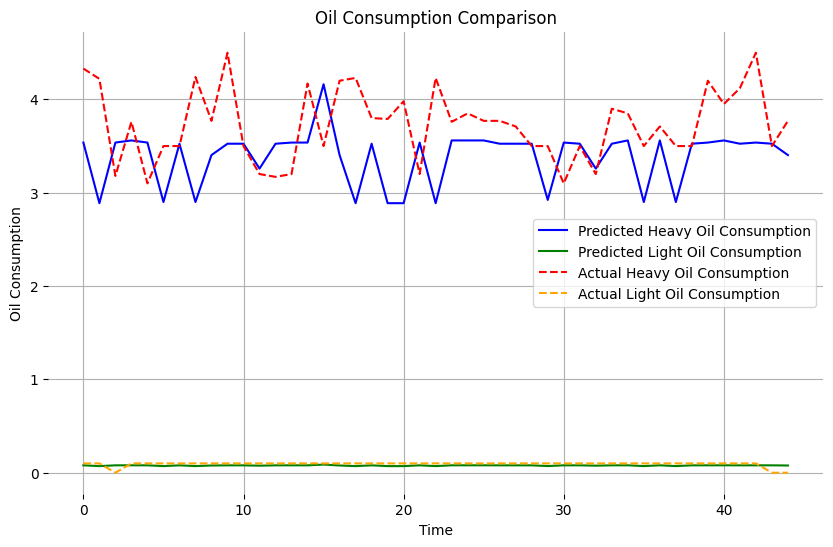

In [14]:
# 提取重油消耗量和轻油消耗量的数据
predicted_heavy_oil = predictions[:, 0]
predicted_light_oil = predictions[:, 1]

actual_heavy_oil = y_test[:, 0]
actual_light_oil = y_test[:, 1]

# 创建一个新的图形并设置标题
plt.figure(figsize=(10, 6))
plt.title('Oil Consumption Comparison')

# 绘制预测值的折线图
plt.plot(predicted_heavy_oil, label='Predicted Heavy Oil Consumption', color='blue')
plt.plot(predicted_light_oil, label='Predicted Light Oil Consumption', color='green')

# 绘制实际值的折线图
plt.plot(actual_heavy_oil, label='Actual Heavy Oil Consumption', linestyle='--', color='red')
plt.plot(actual_light_oil, label='Actual Light Oil Consumption', linestyle='--', color='orange')

# 添加图例和坐标轴标签
plt.legend()
plt.xlabel('Time')
plt.ylabel('Oil Consumption')

# 显示图形
plt.grid()
plt.box()
plt.show()

# 航行状态

In [15]:
anchor_data_df = data_df[data_df['状态'] == '航行24h']
anchor_all_data = all_data[all_data['状态'] == '航行24h']


X = anchor_all_data[['实测时速', '推进器转速 r/min', '风向', '浪向', '风级', '浪级', '航向', ]]
y = anchor_all_data[['重油消耗量', '轻油消耗量']]

In [16]:
# 对风向和浪向进行独热编码
X = pd.get_dummies(X, columns=['风向', '浪向'])

In [17]:
# 将航向的度数改为数值

headings = X['航向']

# 去除度数符号并转换为整数
headings_numeric = headings.str.replace('°', '').astype(int)


# 替换原始数据中的航向列
X['航向'] = headings_numeric
X

,实测时速,推进器转速 r/min,风级,浪级,航向,风向_NE,风向_NW,风向_SE,风向_SW,浪向_NE,浪向_NW,浪向_SE,浪向_SW
8,12.0,100.0,5,4,62,False,True,False,False,False,True,False,False
17,11.6,99.0,6,5,285,False,True,False,False,False,True,False,False
24,13.0,102.0,4,3,107,False,True,False,False,False,True,False,False
25,12.7,102.0,5,3,51,False,True,False,False,False,True,False,False
26,12.7,102.0,5,3,13,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,9.4,99.0,7,5,12,True,False,False,False,True,False,False,False
346,10.0,99.0,6,4,335,True,False,False,False,True,False,False,False
356,5.0,99.0,8,5,352,False,True,False,False,False,True,False,False
357,7.5,99.0,8,5,352,False,True,False,False,False,True,False,False


In [18]:
X

,实测时速,推进器转速 r/min,风级,浪级,航向,风向_NE,风向_NW,风向_SE,风向_SW,浪向_NE,浪向_NW,浪向_SE,浪向_SW
8,12.0,100.0,5,4,62,False,True,False,False,False,True,False,False
17,11.6,99.0,6,5,285,False,True,False,False,False,True,False,False
24,13.0,102.0,4,3,107,False,True,False,False,False,True,False,False
25,12.7,102.0,5,3,51,False,True,False,False,False,True,False,False
26,12.7,102.0,5,3,13,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,9.4,99.0,7,5,12,True,False,False,False,True,False,False,False
346,10.0,99.0,6,4,335,True,False,False,False,True,False,False,False
356,5.0,99.0,8,5,352,False,True,False,False,False,True,False,False
357,7.5,99.0,8,5,352,False,True,False,False,False,True,False,False


In [19]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print("训练集大小:", X_train.shape[0])
print("验证集大小:", X_val.shape[0])
print("测试集大小:", X_test.shape[0])

训练集大小: 63
验证集大小: 21
测试集大小: 22


In [20]:
#X_train = X[0:len(anchor_data_df)]
X_train = np.asarray(X_train).astype('float32')

#y_train = y[0:len(anchor_data_df)]
y_train = np.asarray(y_train).astype('float32')

In [21]:
X_train, y_train

(array([[ 13. , 101. ,   5. ,   4. , 234. ,   1. ,   0. ,   0. ,   0. ,
           1. ,   0. ,   0. ,   0. ],
        [ 11.9,  99. ,   4. ,   3. , 225. ,   1. ,   0. ,   0. ,   0. ,
           1. ,   0. ,   0. ,   0. ],
        [ 12.1, 105. ,   5. ,   4. ,  13. ,   1. ,   0. ,   0. ,   0. ,
           1. ,   0. ,   0. ,   0. ],
        [ 12.3,  99. ,   5. ,   4. , 204. ,   1. ,   0. ,   0. ,   0. ,
           1. ,   0. ,   0. ,   0. ],
        [ 12.4,  99. ,   5. ,   4. ,   8. ,   0. ,   0. ,   0. ,   1. ,
           0. ,   0. ,   0. ,   1. ],
        [ 12. ,  99. ,   5. ,   4. ,  99. ,   0. ,   0. ,   1. ,   0. ,
           0. ,   0. ,   1. ,   0. ],
        [ 11.3,  99. ,   4. ,   3. , 218. ,   0. ,   0. ,   0. ,   1. ,
           0. ,   0. ,   0. ,   1. ],
        [ 10.5,  99. ,   5. ,   4. , 140. ,   0. ,   0. ,   1. ,   0. ,
           0. ,   0. ,   1. ,   0. ],
        [ 12.5,  99. ,   4. ,   3. , 176. ,   1. ,   0. ,   0. ,   0. ,
           1. ,   0. ,   0. ,   0. ],
        [ 

In [22]:
#X_test = X[len(anchor_data_df)::]
X_test = np.asarray(X_test).astype('float32')

#y_test = y[len(anchor_data_df)::]
y_test = np.asarray(y_test).astype('float32')

In [23]:
X_test, y_test

(array([[  8.3,  99. ,   8. ,   6. ,  18. ,   1. ,   0. ,   0. ,   0. ,
           1. ,   0. ,   0. ,   0. ],
        [ 12.3,  99. ,   5. ,   4. , 218. ,   1. ,   0. ,   0. ,   0. ,
           1. ,   0. ,   0. ,   0. ],
        [ 12.7, 102. ,   5. ,   3. ,  13. ,   0. ,   1. ,   0. ,   0. ,
           0. ,   1. ,   0. ,   0. ],
        [ 12.6,  99. ,   6. ,   5. ,  44. ,   1. ,   0. ,   0. ,   0. ,
           1. ,   0. ,   0. ,   0. ],
        [ 11.9, 101. ,   5. ,   4. , 355. ,   1. ,   0. ,   0. ,   0. ,
           1. ,   0. ,   0. ,   0. ],
        [ 10.9,  99. ,   7. ,   5. , 341. ,   0. ,   0. ,   0. ,   1. ,
           0. ,   0. ,   0. ,   1. ],
        [ 11.7, 107. ,   4. ,   2. , 170. ,   0. ,   0. ,   1. ,   0. ,
           0. ,   0. ,   1. ,   0. ],
        [ 12.5, 107. ,   4. ,   3. , 190. ,   1. ,   0. ,   0. ,   0. ,
           1. ,   0. ,   0. ,   0. ],
        [ 13. , 101. ,   4. ,   3. , 155. ,   0. ,   0. ,   1. ,   0. ,
           0. ,   0. ,   1. ,   0. ],
        [ 

In [24]:
# 创建 EarlyStopping 回调对象
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,  # 最小改善量
    patience=20,  # 在停止之前等待的轮数
    restore_best_weights=True  # 恢复在验证集上表现最好的权重
)

# 创建神经网络模型
model = Sequential()

# 添加层
model.add(Dense(units=16, kernel_initializer='uniform', activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=8, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=8, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=2, kernel_initializer='uniform', activation = 'relu'))  # 输出层改为2个单元

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])  # 使用均方误差作为损失函数

# 训练模型
history = model.fit(X_train, y_train, batch_size=25, epochs=800, callbacks=[early_stopping], validation_split=0.25)

Epoch 1/800
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.4570 - loss: 241.4529 - val_accuracy: 0.0000e+00 - val_loss: 244.6506
Epoch 2/800
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0834 - loss: 240.5901 - val_accuracy: 0.0000e+00 - val_loss: 244.5821
Epoch 3/800
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2227 - loss: 243.6172 - val_accuracy: 0.3125 - val_loss: 244.5057
Epoch 4/800
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4729 - loss: 243.7689 - val_accuracy: 1.0000 - val_loss: 244.4433
Epoch 5/800
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5129 - loss: 240.3100 - val_accuracy: 1.0000 - val_loss: 244.3786
Epoch 6/800
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6247 - loss: 238.7584 - val_accuracy: 1.0000 - val_loss: 244.3055
Epoch 7/800
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6397 - loss: 242.5553 - val_accuracy: 1.0000 - val_loss: 244.2220
Epoch 8/800
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5696 - loss: 243.

In [25]:
predictions = model.predict(X_test)
predictions,y_test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


(array([[ 8.153635 ,  0.       ],
        [19.278759 ,  0.       ],
        [ 7.965768 ,  0.       ],
        [ 9.683134 ,  0.       ],
        [27.019968 ,  0.       ],
        [26.221132 ,  0.       ],
        [16.854345 ,  0.       ],
        [18.07221  ,  0.       ],
        [15.801027 ,  0.       ],
        [19.13967  ,  0.       ],
        [20.042015 ,  0.       ],
        [ 9.276934 ,  0.       ],
        [10.60211  ,  0.       ],
        [ 7.9442887,  0.       ],
        [ 7.7780833,  0.       ],
        [25.651775 ,  0.       ],
        [16.2843   ,  0.       ],
        [ 8.624777 ,  0.       ],
        [19.104616 ,  0.       ],
        [27.52363  ,  0.       ],
        [20.184244 ,  0.       ],
        [ 9.639288 ,  0.       ]], dtype=float32),
 array([[21.99,  0.1 ],
        [22.  ,  0.1 ],
        [20.6 ,  0.1 ],
        [21.9 ,  0.1 ],
        [22.  ,  0.1 ],
        [22.5 ,  0.  ],
        [22.29,  0.1 ],
        [24.  ,  0.1 ],
        [21.48,  0.1 ],
        [22.92,  0.

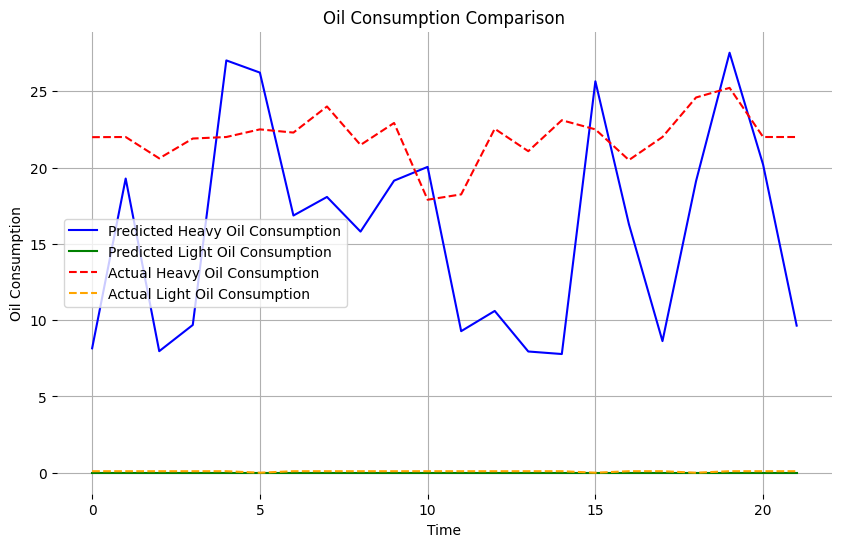

In [26]:
# 提取重油消耗量和轻油消耗量的数据
predicted_heavy_oil = predictions[:, 0]
predicted_light_oil = predictions[:, 1]

actual_heavy_oil = y_test[:, 0]
actual_light_oil = y_test[:, 1]

# 创建一个新的图形并设置标题
plt.figure(figsize=(10, 6))
plt.title('Oil Consumption Comparison')

# 绘制预测值的折线图
plt.plot(predicted_heavy_oil, label='Predicted Heavy Oil Consumption', color='blue')
plt.plot(predicted_light_oil, label='Predicted Light Oil Consumption', color='green')

# 绘制实际值的折线图
plt.plot(actual_heavy_oil, label='Actual Heavy Oil Consumption', linestyle='--', color='red')
plt.plot(actual_light_oil, label='Actual Light Oil Consumption', linestyle='--', color='orange')

# 添加图例和坐标轴标签
plt.legend()
plt.xlabel('Time')
plt.ylabel('Oil Consumption')

# 显示图形
plt.grid()
plt.box()
plt.show()

In [27]:
X_test, y_test

(array([[  8.3,  99. ,   8. ,   6. ,  18. ,   1. ,   0. ,   0. ,   0. ,
           1. ,   0. ,   0. ,   0. ],
        [ 12.3,  99. ,   5. ,   4. , 218. ,   1. ,   0. ,   0. ,   0. ,
           1. ,   0. ,   0. ,   0. ],
        [ 12.7, 102. ,   5. ,   3. ,  13. ,   0. ,   1. ,   0. ,   0. ,
           0. ,   1. ,   0. ,   0. ],
        [ 12.6,  99. ,   6. ,   5. ,  44. ,   1. ,   0. ,   0. ,   0. ,
           1. ,   0. ,   0. ,   0. ],
        [ 11.9, 101. ,   5. ,   4. , 355. ,   1. ,   0. ,   0. ,   0. ,
           1. ,   0. ,   0. ,   0. ],
        [ 10.9,  99. ,   7. ,   5. , 341. ,   0. ,   0. ,   0. ,   1. ,
           0. ,   0. ,   0. ,   1. ],
        [ 11.7, 107. ,   4. ,   2. , 170. ,   0. ,   0. ,   1. ,   0. ,
           0. ,   0. ,   1. ,   0. ],
        [ 12.5, 107. ,   4. ,   3. , 190. ,   1. ,   0. ,   0. ,   0. ,
           1. ,   0. ,   0. ,   0. ],
        [ 13. , 101. ,   4. ,   3. , 155. ,   0. ,   0. ,   1. ,   0. ,
           0. ,   0. ,   1. ,   0. ],
        [ 

In [28]:
anchor_data_df

,日期,实测时速,推进器转速 r/min,风向,浪向,风级,浪级,航向,重油消耗量,轻油消耗量,状态
8,2022.1.9,12.0,100.0,NW,NW,5,4,062°,22.54,0.10,航行24h
17,2022.1.18,11.6,99.0,NW,NW,6,5,285°,22.91,0.10,航行24h
24,2022.1.25,13.0,102.0,NW,NW,4,3,107°,20.99,0.10,航行24h
25,2022.1.26,12.7,102.0,NW,NW,5,3,051°,20.60,0.10,航行24h
26,2022.1.27,12.7,102.0,NW,NW,5,3,013°,20.60,0.10,航行24h
...,...,...,...,...,...,...,...,...,...,...,...
308,2022.11.5,12.0,99.0,NE,NE,4,3,216°,22.88,0.11,航行24h
309,2022.11.6,13.0,101.0,NE,NE,5,4,234°,21.98,0.10,航行24h
313,2022.11.10,12.0,99.0,NE,NE,4,3,320°,21.92,0.10,航行24h
329,2022.11.26,13.7,101.0,SE,SE,4,3,146°,20.59,0.10,航行24h
